In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def quadratic(A, b, x):
    return 0.5 * x.T @ A @ x + b.T @ x

In [17]:
def random_symmetric_with_spectrum(n, eig_min, eig_max, null_space_size, seed=None):

    if seed is not None:
        np.random.seed(seed)

    if null_space_size >= n:
        raise ValueError("Null space size must be strictly less than dimension n")
        
    k = n - null_space_size
    
    eigvals = np.zeros(n)
    
    if k == 1:
        eigvals[null_space_size:] = [eig_max]
    else:
        non_zero_eigs = np.random.uniform(eig_min, eig_max, size=k)
        non_zero_eigs[0] = eig_min
        non_zero_eigs[-1] = eig_max
        eigvals[null_space_size:] = non_zero_eigs


    M = np.random.randn(n, n)
    Q, _ = np.linalg.qr(M)
    
    A = Q @ np.diag(eigvals) @ Q.T
    A = (A + A.T) / 2.0  
    
    return A


def generate_random_quadratic_function(n, eig_min, eig_max, null_space_size, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    A = random_symmetric_with_spectrum(n, eig_min, eig_max, null_space_size)
    c = np.random.randn(n)
    b = A @ c
    
    return A, b

# Quadratic optimization


$$
\begin{equation}
    f(x) = \frac{1}{2}x^T A x + b^T x
\tag{1}
\end{equation}
$$

Where $A$ can be singular, but $A \succeq 0$. Also $b \in C(A)$, otherwise minimizer does not exist.

We are interested in convergence rate of the gradient descent method:

$$
\begin{equation}
x_{k+1} = x_k - \alpha_k \nabla f(x_k)
\tag{2}
\end{equation}
$$

$$ 
    \nabla f(x) = A x + b
    \tag{3}
$$

Here are analysis for different stepsizes

## Optimal constant step size

### Analysis

As function $f(x)$ is convex it has minimizer $x^*$. At each step, consider $e_k = x_k - x^*$ 


$$ x_{k+1}-x_*=(I-\alpha A)x_k+\alpha b-((I-\alpha A)x_*+\alpha b)=(I-\alpha A)(x_k-x_*) $$

$$
\begin{equation}
    e_{k+1}=(I-\alpha A)e_k
    \tag{4}
\end{equation}
$$

After making $k$ steps, got such relation:

$$
\begin{equation}
    e_{k}=(I-\alpha A)^k e_0
    \tag{5}
\end{equation}
$$

Consider orthonormal basis $V = [v_1, \ldots, v_n]$, which formed of eigenvectors of $A$. $V$ always exists as $A$ is symmetric. 

$$
    e_k = \sum_{i=0}^nc_i^{(k)}v_i=(I-\alpha A)^k\sum_{i=0}^nc_i^{(0)}v_i=\sum_{i=0}^n(1-\alpha \lambda_i)^kc_i^{(0)}v_i
$$

Let us consider individual axes of our basis:

 - $\lambda_j=0$, then for any $k$: $c_j^{(k)}=c_j^{(0)}$, but that doesn't affect minimization as we always can chose such $x^*$  
 that have the same component in the null space of $A$ as $x_0$, resulting in $c_j^{(0)}=0$ for j where $\lambda_j=0$

 - $\lambda_j\neq0$, then for any $k$ have $|c_j^{(k)}|=|(1-\alpha\lambda_j)|^k |c_j^{(0)}|$

Note that $\lambda_1 \geq \lambda_2 \geq ... \geq \lambda_m > 0$, thus, convergence rate is determined by $r = max\{|1 - \alpha \lambda_1 |, |1 - \alpha \lambda_m |\}$, and have that:

$$ \| e_k \| \leq r^k \| e_0 \|  $$

$r$ is minimal when $\alpha = \frac{2}{\lambda_{1} + \lambda_{m}}$, then:

$$
r = \frac{\lambda_{1}-\lambda_{m}}{\lambda_{1}+\lambda_{m}}
$$


Thus 

$$ \|x_k - x^* \| \leq \left( \frac{\lambda_{1}-\lambda_{m}}{\lambda_{1}+\lambda_{m}} \right)^k \|x_0 - x^* \|$$

Which gives *linear* convergence rate.

### Implementation

In [4]:
def gradient_descent_quadratic(A, b, x0, lr, max_iters=1000, tol=1e-10):
    """
    Perform gradient descent on f(x) = 1/2 x^T A x - b^T x
    with constant learning rate lr.
    
    Returns: x, history of function values
    """
    x = x0.copy()
    values = []

    for k in range(max_iters):
        grad = A @ x + b
        x = x - lr * grad

        f_val = quadratic(A, b, x)
        values.append(f_val)

        if np.linalg.norm(grad) < tol:
            break

    return x, np.array(values)

### Experiments

Different condition numbers

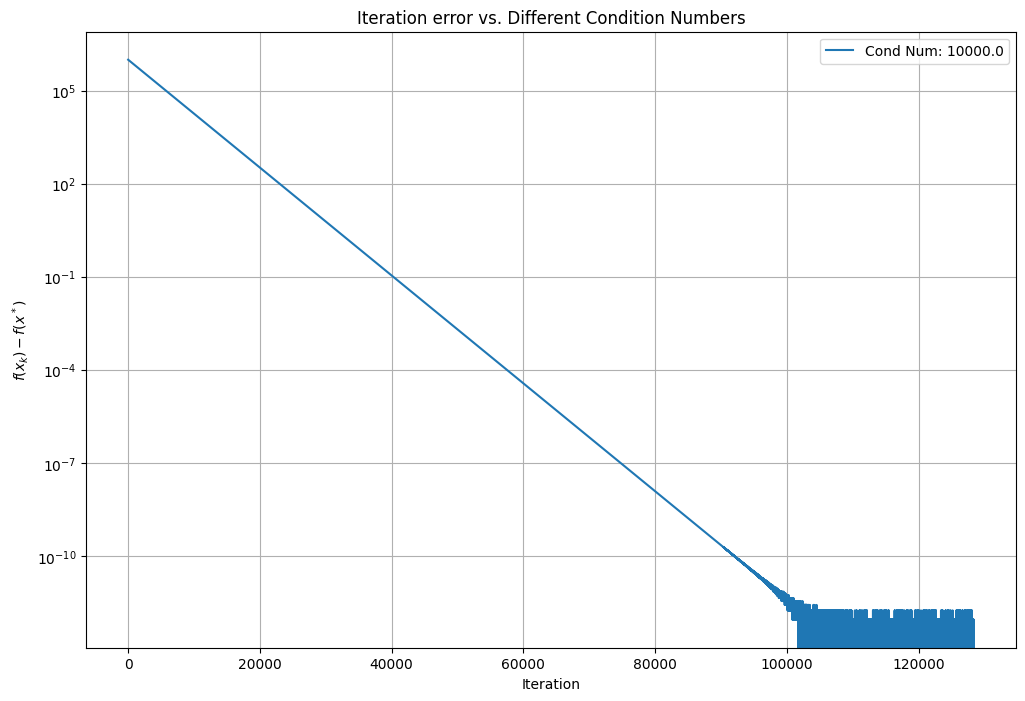

In [21]:
condition_numbers = [10000]
n = 2
max_iters =  1000000
tol = 1e-6
x0 = 10 * np.ones(n)

plt.figure(figsize=(12, 8))

for cond_num in condition_numbers:

    eig_min = 1.0 
    eig_max = eig_min * cond_num

    A, b = generate_random_quadratic_function(
        n=n,
        eig_min=eig_min,
        eig_max=eig_max,
        null_space_size=0,
        seed=42
    )

    lr = 2 / (eig_max + eig_min)

    optimizer, values = gradient_descent_quadratic(A, b, x0=x0, max_iters=max_iters, lr=lr, tol=tol)

    x_star = -np.linalg.inv(A) @ b
    f_star = quadratic(A, b, x_star)
    error = np.array(values).flatten() - f_star.item()

    plt.plot(error, label=f'Cond Num: {cond_num:.1f}')

plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('$f(x_k) - f(x^*)$')
plt.title('Iteration error vs. Different Condition Numbers')
plt.grid(True)
plt.legend()
plt.show()

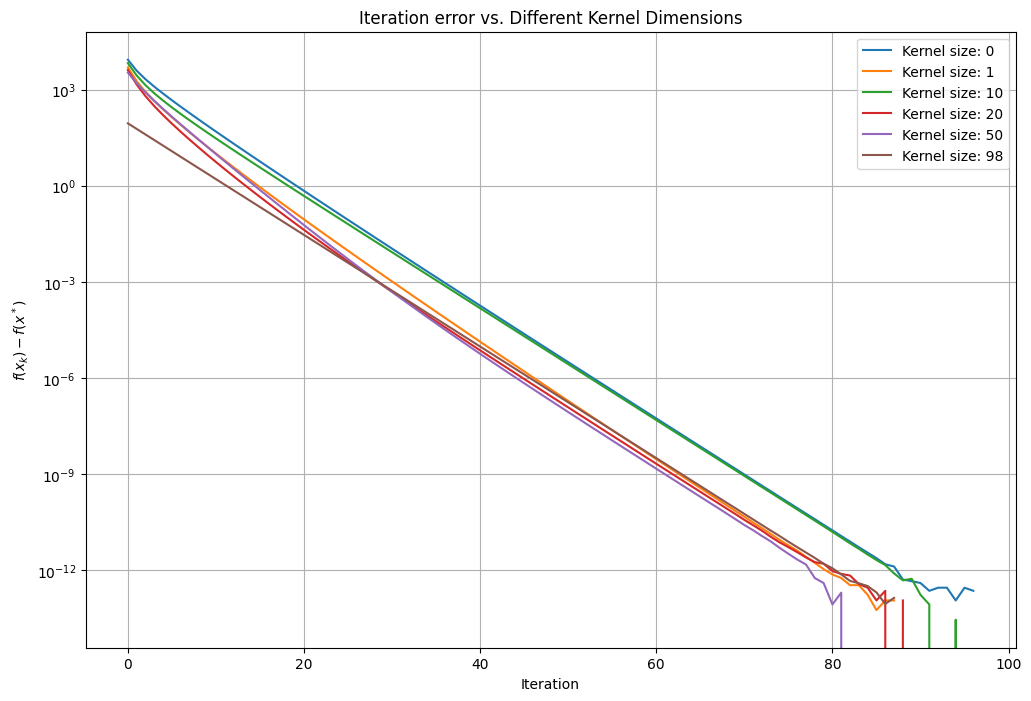

In [6]:
kernel_dimensions = [0, 1,10, 20, 50, 98]
n = 100
eig_min = 1.0
eig_max = 10.0
max_iters = 20000
tol = 1e-6
x0 = 10 * np.ones(n)

plt.figure(figsize=(12, 8))

for kernel_dim in kernel_dimensions:

    A, b = generate_random_quadratic_function(
        n=n,
        eig_min=eig_min,
        eig_max=eig_max,
        null_space_size=kernel_dim,
        seed=42
    )

    lr = 2 / (eig_max + eig_min)

    optimizer, values = gradient_descent_quadratic(A, b, x0=x0, max_iters=max_iters, lr=lr, tol=tol)

    x_star = -np.linalg.pinv(A) @ b
    f_star = quadratic(A, b, x_star)
    error = np.array(values).flatten() - f_star.item()
    plt.plot(error, label=f'Kernel size: {kernel_dim}')

plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('$f(x_k) - f(x^*)$')
plt.title('Iteration error vs. Different Kernel Dimensions')
plt.grid(True)  
plt.legend()
plt.show()

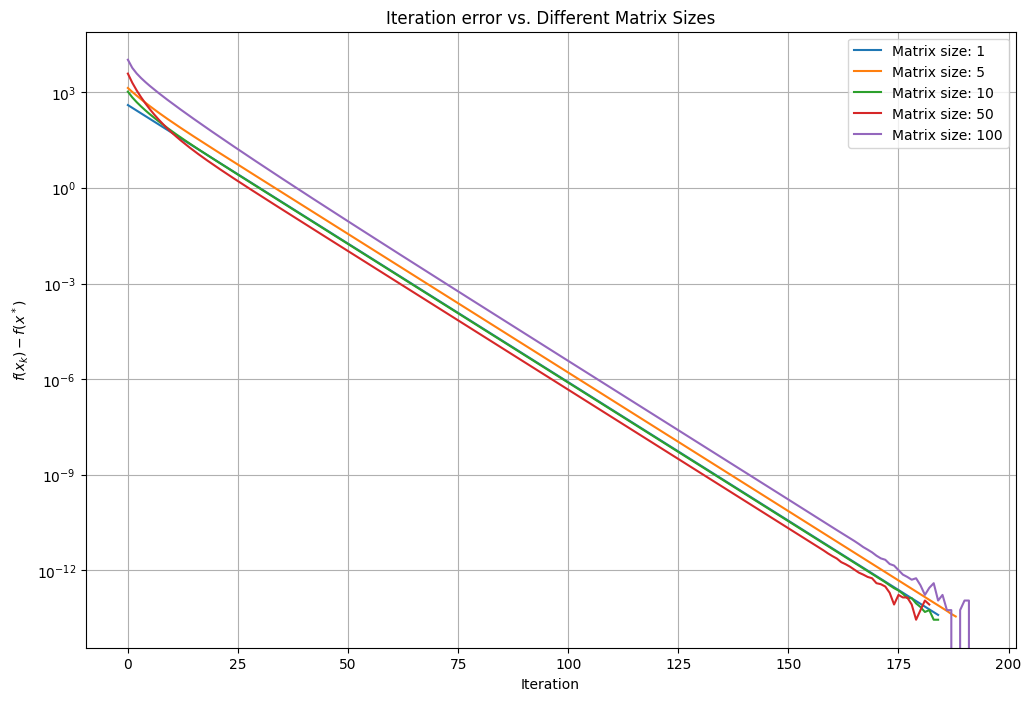

In [7]:
matrix_sizes = [1, 5, 10, 50, 100]
eig_min = 0.5
eig_max = 10
max_iters = 1000
tol = 1e-6

plt.figure(figsize=(12, 8))

for matrix_size in matrix_sizes:

    x0 = 10 * np.ones(matrix_size)

    A, b = generate_random_quadratic_function(
        n=matrix_size,
        eig_min=eig_min,
        eig_max=eig_max,
        null_space_size=0,
        seed=42
    )

    lr = 2 / (eig_max + eig_min)

    optimizer, values = gradient_descent_quadratic(A, b, x0=x0, max_iters=max_iters, lr=lr, tol=tol)

    x_star = -np.linalg.inv(A) @ b
    f_star = quadratic(A, b, x_star)
    error = np.array(values).flatten() - f_star.item()

    plt.plot(error, label=f'Matrix size: {matrix_size}')

plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('$f(x_k) - f(x^*)$')
plt.title('Iteration error vs. Different Matrix Sizes')
plt.grid(True)
plt.legend()
plt.show()


## Quadratic optimization problem under exact line search

### Analysis

Under exact line search we have that:

$$\alpha_k = \arg\min_{\alpha \geq 0} f(x_k + \alpha \nabla f(x_k))$$

For quadratic function $f(x) = \frac{1}{2}x^T A x + b^T x$ we have that:

$$\alpha_k = \frac{\nabla f(x_k)^\top \nabla f(x_k)}{\nabla f(x_k)^\top A \nabla f(x_k)} $$


Optimizing $f(x)$ is equivalent to minimizing 

$$g(x) = f(x^*) + \frac{1}{2}(x - x^*)^\top A (x - x^*) $$

Using exact line search we can derive that:

$$g(x_{k+1}) = \left(1 -  \frac{\| \nabla g(x_k) \|^4}{(\nabla g(x_k)^\top A \nabla g(x_k)) (\nabla g(x_k)^\top A ^ {-1} \nabla g(x_k))} \right)g(x_k)$$

Now, assuming that $A$ is nonsingular.

Using Kantorovich's inequality we can show that (TODO: Derive):

$$
\frac{\| \nabla g(x_k) \|^4}{(\nabla g(x_k)^\top A \nabla g(x_k)) (\nabla g(x_k)^\top A ^ {-1} \nabla g(x_k))} \geq \frac{4 \lambda_1 \lambda_2}{(\lambda_1 + \lambda_2)^2}
$$

So that:

$$
g(x_{k+1}) \leq \left( \frac{\lambda_1 - \lambda_n}{\lambda_1 + \lambda_n}   \right)^2 g(x_k)
$$

### Implementation

In [13]:
def exact_line_search_quadratic(A, b, x0, max_iters=1000, tol=1e-14):

    x = x0.copy()
    values = []
    etas = []

    for k in range(max_iters):
        g = A @ x + b
        grad_norm = np.linalg.norm(g)

        eta = np.exp(np.log(g.T @ g) - np.log(g.T @ (A @ g)))
        etas.append(eta)

        x = x - eta * g

        f_val = 0.5 * x @ (A @ x) + b @ x
        values.append(f_val)

        if np.linalg.norm(g) < tol:
            break

    return x, np.array(values)

### Experiments

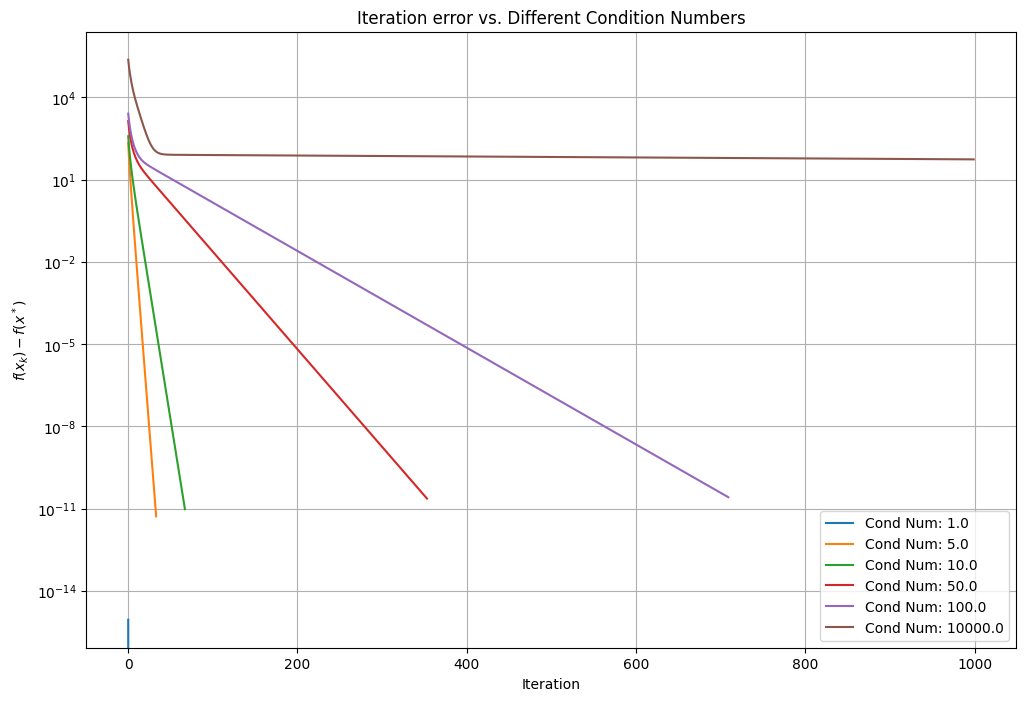

In [22]:
condition_numbers = [1, 5, 10, 50, 100, 10000]
n = 10
max_iters = 1000
tol = 1e-5
x0 = 10 * np.ones(n)

plt.figure(figsize=(12, 8))

for cond_num in condition_numbers:

    eig_min = 1.0 
    eig_max = eig_min * cond_num

    A, b = generate_random_quadratic_function(
        n=n,
        eig_min=eig_min,
        eig_max=eig_max,
        null_space_size=0,
        seed=42
    )

    lr = 2 / (eig_max + eig_min)

    optimizer, values = exact_line_search_quadratic(A, b, x0=x0, max_iters=max_iters, tol=tol)

    x_star = -np.linalg.inv(A) @ b
    f_star = quadratic(A, b, x_star)
    error = np.array(values).flatten() - f_star.item()

    plt.plot(error, label=f'Cond Num: {cond_num:.1f}')

plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('$f(x_k) - f(x^*)$')
plt.title('Iteration error vs. Different Condition Numbers')
plt.grid(True)
plt.legend()
plt.show()

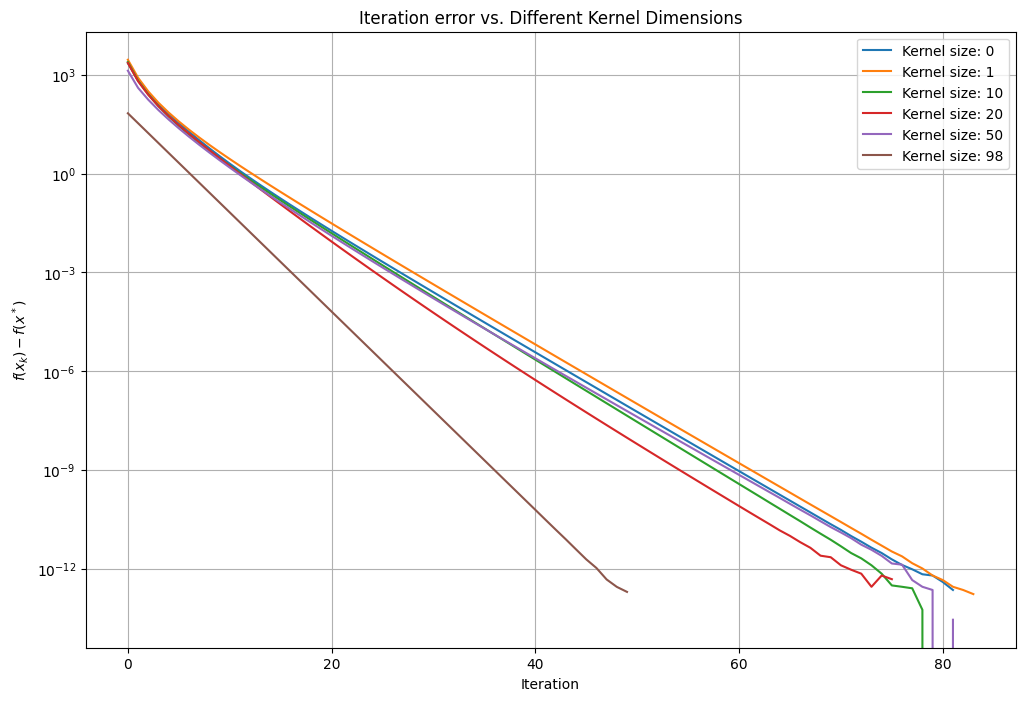

In [16]:
kernel_dimensions = [0, 1,10, 20, 50, 98]
n = 100
eig_min = 1.0
eig_max = 10.0
max_iters = 20000
tol = 1e-6
x0 = 10 * np.ones(n)

plt.figure(figsize=(12, 8))

for kernel_dim in kernel_dimensions:

    A, b = generate_random_quadratic_function(
        n=n,
        eig_min=eig_min,
        eig_max=eig_max,
        null_space_size=kernel_dim,
        seed=42
    )

    lr = 2 / (eig_max + eig_min)

    optimizer, values = exact_line_search_quadratic(A, b, x0=x0, max_iters=max_iters,  tol=tol)

    x_star = -np.linalg.pinv(A) @ b
    f_star = quadratic(A, b, x_star)
    error = np.array(values).flatten() - f_star.item()
    plt.plot(error, label=f'Kernel size: {kernel_dim}')

plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('$f(x_k) - f(x^*)$')
plt.title('Iteration error vs. Different Kernel Dimensions')
plt.grid(True)  
plt.legend()
plt.show()